In [1]:
# Helper function to check if the code is running in Google Colab
def is_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

# Usage
if is_colab():
    print("Running in Google Colab")
else:
    print("Not running in Google Colab")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow import keras as ks
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
import scipy

Not running in Google Colab


In [4]:
# Path to the zip file
data_dir = "./Data"
data_path = f"{data_dir}/Xtrain.mat"

data = scipy.io.loadmat(data_path)
df = pd.DataFrame(data['Xtrain'])
df

,0
0,86
1,141
2,95
3,41
4,22
...,...
995,61
996,20
997,12
998,13


In [5]:
dataset = np.array(df)
dataset.reshape(-1,1)
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [6]:
results = {}
loss_dict = {}

lookback_Simple = 35
lookback_LSTM = 5
lookback_GRU = 15
forecast_steps = 200

# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

def recursive_forecast(model, last_values, steps, lookback):
    input_seq = last_values[-lookback:].reshape(1, lookback, 1)
    preds = []
    for _ in range(steps):
        pred = model.predict(input_seq, verbose=0)
        preds.append(pred[0, 0])
        input_seq = np.append(input_seq[:, 1:, :], [[[pred[0, 0]]]], axis=1)
    return np.array(preds).reshape(-1, 1)

split_index = len(dataset) - 200
train_data = dataset[:800]
test_data = dataset[800:]

X_Simple, y_Simple = create_sequences(train_data, lookback_Simple)
X_LSTM, y_LSTM = create_sequences(train_data, lookback_LSTM)
X_GRU, y_GRU = create_sequences(train_data, lookback_GRU)

# Simple RNN Model
Simple_model = ks.Sequential([
    ks.layers.SimpleRNN(128, activation='relu', input_shape=(lookback_Simple, 1)),
    ks.layers.Dropout(0.2),
    ks.layers.Dense(1)
])
Simple_model.compile(optimizer='adam', loss='mse')
hist_simple = Simple_model.fit(X_Simple, y_Simple, epochs=10, batch_size=32, verbose=0)
loss_dict['Simple'] = hist_simple.history['loss']
preds_Simple = recursive_forecast(Simple_model, train_data, forecast_steps, lookback_Simple)
preds_Simple_inv = scaler.inverse_transform(preds_Simple)

# LSTM Model
LSTM_model = ks.Sequential([
    ks.layers.LSTM(128, activation='relu', input_shape=(lookback_LSTM, 1)),
    ks.layers.Dropout(0.2),
    ks.layers.Dense(1)
])
LSTM_model.compile(optimizer='adam', loss='mse')
hist_LSTM = LSTM_model.fit(X_LSTM, y_LSTM, epochs=10, batch_size=32, verbose=0)
loss_dict['LSTM'] = hist_LSTM.history['loss']
preds_LSTM = recursive_forecast(LSTM_model, train_data, forecast_steps, lookback_LSTM)
preds_LSTM_inv = scaler.inverse_transform(preds_LSTM)

# GRU Model
GRU_model = ks.Sequential([
    ks.layers.GRU(128, activation='relu', input_shape=(lookback_GRU, 1)),
    ks.layers.Dropout(0.2),
    ks.layers.Dense(1)
])
GRU_model.compile(optimizer='adam', loss='mse')
hist_GRU = GRU_model.fit(X_GRU, y_GRU, epochs=10, batch_size=32, verbose=0)
loss_dict['GRU'] = hist_GRU.history['loss']
preds_GRU = recursive_forecast(GRU_model, train_data, forecast_steps, lookback_GRU)
preds_GRU_inv = scaler.inverse_transform(preds_GRU)

# True future values
y_true_inv = scaler.inverse_transform(test_data.reshape(-1, 1))

# Evaluation
results['Simple'] = {
    'MAE': mean_absolute_error(y_true_inv, preds_Simple_inv),
    'MSE': mean_squared_error(y_true_inv, preds_Simple_inv)
}
results['LSTM'] = {
    'MAE': mean_absolute_error(y_true_inv, preds_LSTM_inv),
    'MSE': mean_squared_error(y_true_inv, preds_LSTM_inv)
}
results['GRU'] = {
    'MAE': mean_absolute_error(y_true_inv, preds_GRU_inv),
    'MSE': mean_squared_error(y_true_inv, preds_GRU_inv)
}



C:\Users\cisva\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\cisva\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\cisva\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


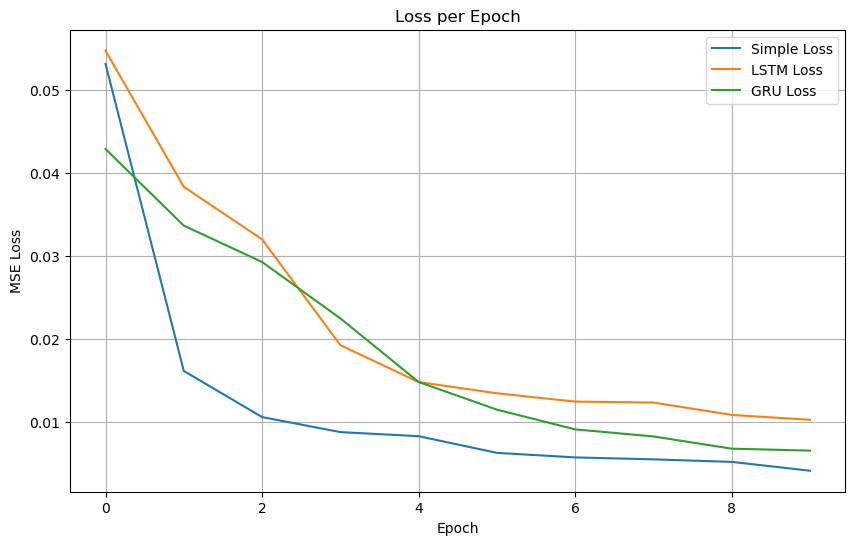

In [7]:
# Plot loss
plt.figure(figsize=(10, 6))
for key in loss_dict:
    plt.plot(loss_dict[key], label=f"{key} Loss")
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.show()

Simple - MAE: 37.1075, MSE: 2692.6371
LSTM - MAE: 35.8000, MSE: 2139.7035
GRU - MAE: 46.5725, MSE: 3625.9547


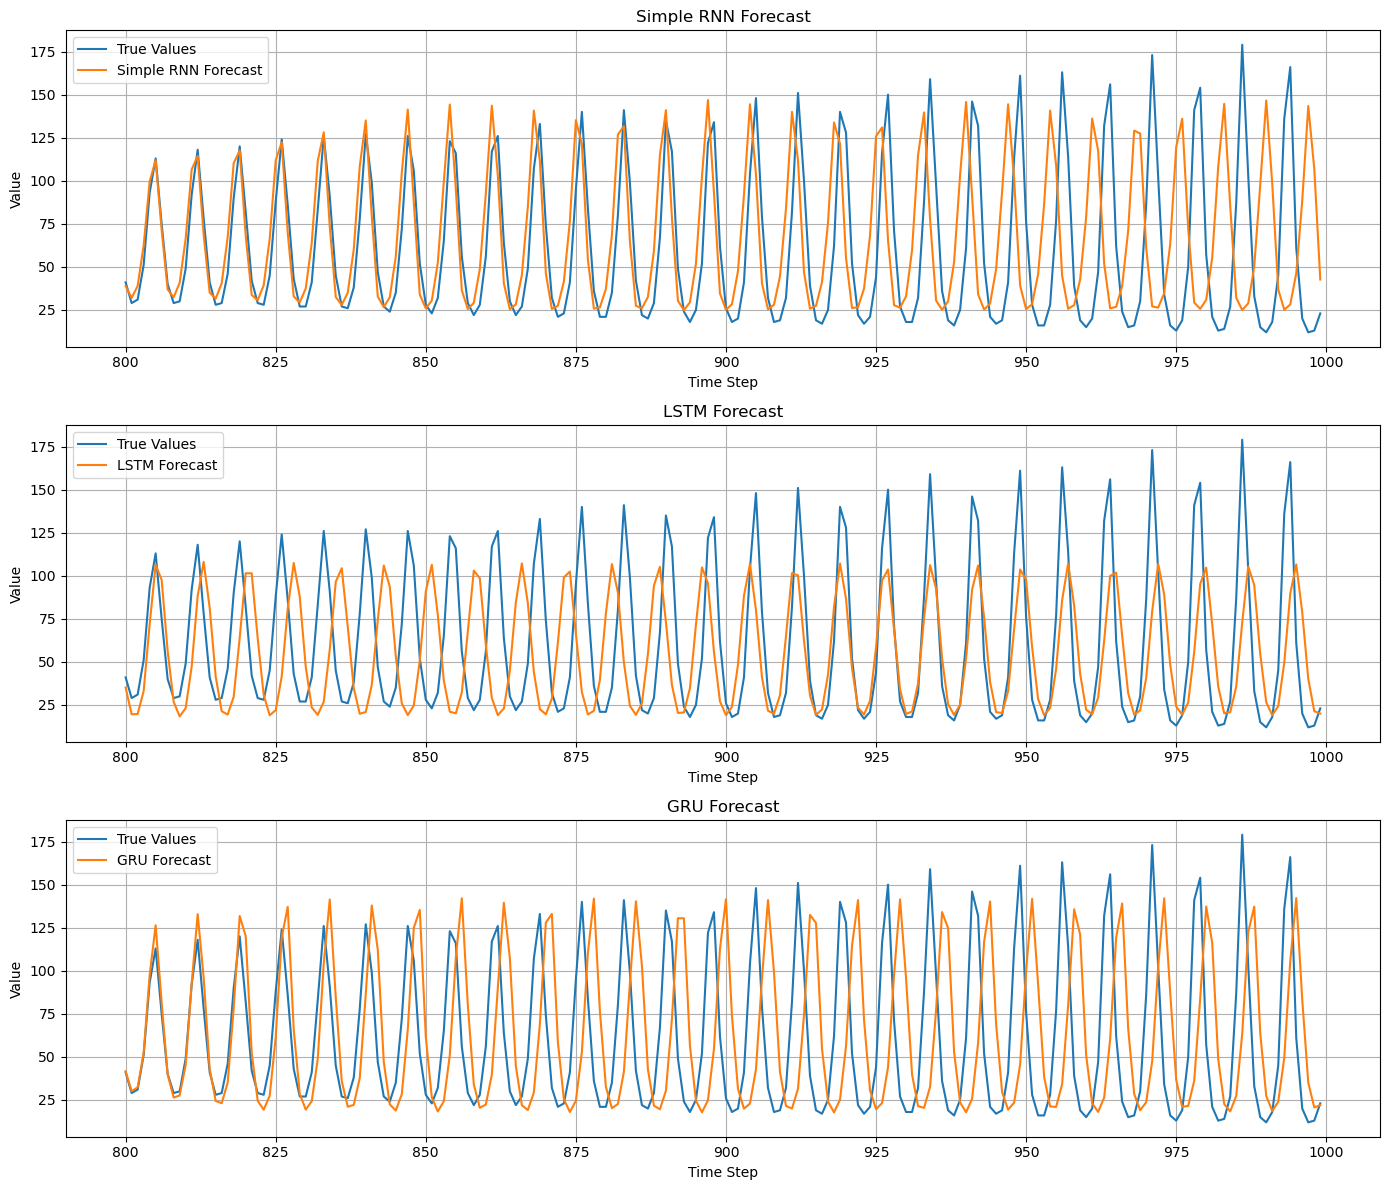

In [8]:
# Print results
for model_name, metrics in results.items():
    print(f"{model_name} - MAE: {metrics['MAE']:.4f}, MSE: {metrics['MSE']:.4f}")

# Plot in separate subplots
fig, axs = plt.subplots(3, 1, figsize=(14, 12))

axs[0].plot(range(800, 1000), y_true_inv, label='True Values')
axs[0].plot(range(800, 1000), preds_Simple_inv, label='Simple RNN Forecast')
axs[0].set_title('Simple RNN Forecast')
axs[0].set_xlabel('Time Step')
axs[0].set_ylabel('Value')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(range(800, 1000), y_true_inv, label='True Values')
axs[1].plot(range(800, 1000), preds_LSTM_inv, label='LSTM Forecast')
axs[1].set_title('LSTM Forecast')
axs[1].set_xlabel('Time Step')
axs[1].set_ylabel('Value')
axs[1].legend()
axs[1].grid(True)

axs[2].plot(range(800, 1000), y_true_inv, label='True Values')
axs[2].plot(range(800, 1000), preds_GRU_inv, label='GRU Forecast')
axs[2].set_title('GRU Forecast')
axs[2].set_xlabel('Time Step')
axs[2].set_ylabel('Value')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Main loop used to determine 